#### Prerequisites

- Basic familiarity with [Numpy](https://numpy.org/doc/stable/user/quickstart.html)
- Basic familiarity with [Pyplot](https://matplotlib.org/stable/tutorials/introductory/pyplot.html)
- Basic familiarity with [magic methods](https://docs.python.org/3/reference/datamodel.html#specialnames)


# Outline

<a name="outline"></a>

- [Section 1](#section-1): Data generation
- [Section 2](#section-2): K-means Clustering
- [Section 3](#section-3): Initialisation of K-means
- [Section 4](#section-4): Hierarchical Clustering

# K-means and Hierarchical clustering

The purpose of this notebook is to understand and implement two popular unsupervised learning methods to cluster data points; K-means clustering and hierarchical clustering.  

We will work on data found in the `samples.csv` and `labels.csv` files.

<a name="section-1"></a>
# Section 1: Data generation ([index](#outline))


In [ ]:
# imports
import numpy as np
import numpy.testing as npt # for testing.
import matplotlib.animation as animation

from tqdm.auto import tqdm # just a fancy progress bar
import matplotlib.pyplot as plt
from heapq import heappush, heappop, heapify # to improve speed in hierarchical clustering
from matplotlib import cm # color maps

# Initial global configuration for matplotlib
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

We load in a dataset that has been generated using the `make_blobs` function from `sklearn.datasets`. This can be found in `samples.csv` which is located in the same folder as this notebook on Blackboard.

Although clustering methods are commonly used in unsupervised learning settings where no label *y* (cluster assignments) is available, we typically generate synthetic data with ground truth clusters so that we can assess how well a particular method has worked. The labels for this dataset are given in `labels.csv`.

To simplify our setting, we will only consider data points in 3-dimensional space but these methods can also be used in higher dimensions and you are encouraged to try out these scenarios. The dataset contains 400 samples that belong to (exactly) one of 5 clusters.

If you run this notebook locally on your machine, you will simply need to place the `csv` file in the same directory as this notebook.
If you run this notebook on Google Colab, you will need to

  `from google.colab import files`

  `upload = files.upload()`

and then upload it from your local downloads directory.

In [ ]:
from google.colab import files

upload = files.upload()

Saving labels.csv to labels.csv
Saving samples.csv to samples.csv


In [ ]:
## EDIT HERE
PATH = ''
data = np.loadtxt(PATH + 'samples.csv', delimiter=',', skiprows=1)
cluster_assignment = np.loadtxt(PATH + 'labels.csv', delimiter=',', skiprows=1)
print(data.shape)
print(cluster_assignment.shape)

(400, 3)
(400,)


`cluster_assignment` is the ground-truth that represents the true membership of each point to one of the five clusters.
When clustering in practice, we don't have access to these true assignments. The aim is therefore to **discover** these assignments, without having a train-split with given labels (as we do in supervised learning).

As $K$-means and hierarchical clustering both rely on **distances**, it is **important we standardise the data before** applying any methods. Note
as we don't have a test or validation set (in contrast to previous notebooks), we don't need to code a standardisation of the test dataset using the mean and standard deviation of the training set.

In [ ]:
def standardise(X):
    """
    Standardise features.

    Parameters:
        X (np.array): Feature matrix.

    Returns:
        X_std (np.array): Standardised feature matrix
    """

    mu = np.mean(X, axis=0, keepdims=True)
    sigma = np.std(X, axis=0, keepdims=True)
    X_std = (X - mu) / sigma

    return X_std

In [ ]:
X = standardise(data)


We will now produce two plots from our data which:
1. represent the information a clustering procedure will see
 *i.e.* only the three features.
2. visualise the clusters generated. Here we can use `cluster_assignment` to visualise cluster membership.

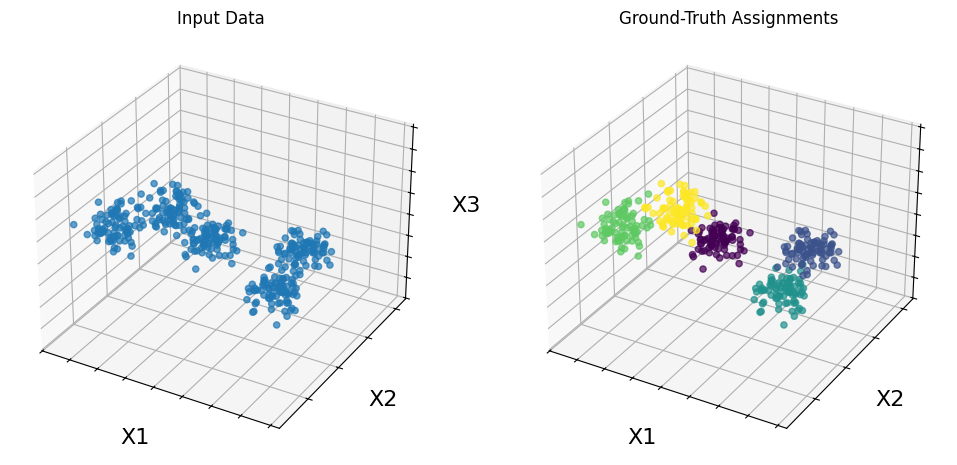

In [ ]:
# Visualise 3D data
fig = plt.figure(figsize=(12, 8))
ax1, ax2 = fig.add_subplot(121, projection='3d'), fig.add_subplot(122, projection='3d')

ax1.scatter(X[:, 0], X[:, 1], X[:, 2],  alpha=0.7)
ax1.set_title('Input Data')
ax1.set_xticklabels([]); ax1.set_yticklabels([]); ax1.set_zticklabels([]);
ax1.set_xlabel('X1'); ax1.set_ylabel('X2'); ax1.set_zlabel('X3')

# We use cluster_assignment here only to visualise the ground-truth
# (the ideal clustering) in practice we don't have this ground-truth.

ax2.scatter(X[:, 0], X[:, 1], X[:, 2], alpha=0.7, c=cluster_assignment)
ax2.set_title('Ground-Truth Assignments')
ax2.set_xticklabels([]); ax2.set_yticklabels([]); ax2.set_zticklabels([]);
ax2.set_xlabel('X1'); ax2.set_ylabel('X2'); ax2.set_zlabel('X3');

# Show the plot
plt.show()

<a name="section-2"></a>

# Section 2: $K$-means Clustering ([index](#outline))

$K$-means is a simple clustering algorithm which aims to minimise the *within-distance*, $W(C)$, of a clustering solution. This is defined as:
$$W(C)=\frac{1}{2} \sum_{l=1}^K \frac{1}{|c_k|}\sum_{i, j \in c_k}||\mathbf{x}^{(i)} - \mathbf{x}^{(j)}||^2$$


For a predefined number of clusters $K$, the $K$-means algorithm follows the following steps:

0. **Initialisation:** Randomly assign every sample $\mathbf{x}^{(i)}$ to one of the $K$-clusters.
1. **Compute the centroid** of each of the $K$- clusters:
$$\mathbf{m}_k = \frac{1}{|c_k|} \sum_{i \in c_k} \mathbf{x}^{(i)}, \quad k=1, \ldots, K$$
2. **Reassign each $\mathbf{x}^{(i)}$** to the closest centroid. At iteration $t$ we define $k_i^{(t)}$ as the cluster $\mathbf{x}^{(i)}$ is assigned to. The reassignment is determined by:

$$ k_i^{(t+1)} = \underset{k}{\text{argmin}}||\mathbf{x}^{(i)} - \mathbf{m}_k||^2$$
3. Repeat step (1) and (2) until at least one of the following conditions is met:

  - Assignments do not change.
  - The within-distance $W(C)$ converges within some predefined tolerance `epsilon`.
  - The number of iterations exceeds a predefined number `max_iters`.


By applying this algorithm to the dataset generated above, we expect the following clustering trajectory:

![kmeans](https://raw.githubusercontent.com/barahona-research-group/mfds-resources/main/images/kmeans_k5.gif)

To implement this K-means algorithm we develop some useful functions:

- `compute_centroids`: given samples and their cluster assignments, return the corresponding centroids (for step 1).
- `compute_within_distance`: given centroids, samples, and their cluster assignments, compute the within-distance (used for step 3 convergence check).
- `kmeans_assignments`: given centroids and samples, return the new cluster assignments (for step 2).

**Edge case: no assignments to a cluster**

In `kmeans_assignments` and `compute_within_distance` functions, we need to consider an edge case. It is possible that when we reassign all samples in step 2, a centroid does not get any samples assigned to it and we are left with an empty cluster. If this happens we will set the centroid as equal to `np.inf` at all features, this avoids issues with `NaN`, which would otherwise arise at the next iteration. We will need to consider this case separately.


An equivalent formulation of $W(C)$ (page 105 in the notes) that we use in implementation is given by:

$$
W(C) = \sum_{k=1}^K \sum_{i \in c_k} ||\mathbf{x}^{(i)} - \mathbf{m}_k||^2
$$

where $\mathbf{m}_k$ denotes the centroid of the $k$-th cluster.

Now we are ready to implement `compute_within_distance`.

In [ ]:
# EDIT THIS FUNCTION
def compute_within_distance(centroids, X, labels):
    """
    Compute the within-cluster distance.

    Parameters:
        centroids (np.ndarray): Centroids matrix, shape (k, p).
        X (np.ndarray): Samples matrix, shape (N, p).
        labels (np.ndarray): Cluster index of each sample, shape (N,).

    Retruns:
        within_distance (float): Within-cluster distance.
    """

    within_distance = 0.0
    K, p = centroids.shape

    # calculate the contribution to W(C) for each cluster
    for l in range(len(centroids)):
        centroid = centroids[l]
        # skip empty clusters
        if np.isinf(centroid).any():
            continue

        # Select samples belonging to label=l.
        X_cluster = X[labels == l]

        # We need to add the `X_cluster` contribution to `within_distance`
        # Compute the W(C) contribution for each sample

        cluster_se = (X_cluster - centroid)**2 # <-- SOLUTION
        assert cluster_se.shape == (len(X_cluster), p) # <-- SOLUTION

        # Calculate the total contribution for the lth cluster
        # and add to the running total

        within_distance += np.sum(cluster_se) # <-- SOLUTION

    return within_distance


Now we implement `compute_centroids` to be used in step 1. Here, if we identify an empty cluster, we set all feature values of the centroid to `np.inf`.

In [ ]:
# EDIT THIS FUNCTION
def compute_centroids(K, X, labels):
    """
    Compute the centroids of the clustered points X.

    Parameters:
        K (int): The number of clusters.
        X (np.ndarray): Samples matrix, shape (N, p).
        labels (np.ndarray): Cluster index of each sample, shape (N,).

    Returns:
        centroids (np.ndarray): Centroids matrix, shape (k, p).
    """
    N, p = X.shape

    centroids = np.zeros((K, p))

    # EDIT THE NEXT LINES
    for label in range(K):
        cluster_X_l = X[labels == label] # <-- SOLUTION
        # if cluster is empty, set all features values to Inf
        if cluster_X_l.shape[0] == 0:
          centroids[label] = np.inf # <-- SOLUTION
        else:
          centroids[label] = cluster_X_l.mean(axis=0) # <-- SOLUTION


    return centroids


Make sure the following simple test case runs successfully.

In [ ]:
# Test case.
X_test = np.array([[1, 1, 0],
                    [2, 2, 1],
                    [5, 3, 4],
                    [8, 3, 2]])
labels = np.array([0, 0, 1, 1])

centroids = np.array([[1.5, 1.5, 0.5],
                      [6.5, 3, 3]])

# Test compute_centroids
npt.assert_allclose(compute_centroids(2, X_test, labels),  centroids)


# Test compute_within_distance.
npt.assert_allclose(compute_within_distance(centroids, X_test, labels), 8.0)

Now, we define the `kmeans_assignments` function to be used in step 2. As we have set the centroids of any empty clusters to `np.inf` we don't need to consider this case separately as we can calculate the distance to `[[np.inf, ... , np.inf]]` (it will just be `[[np.inf, ... , np.inf]]`).

In [ ]:
# EDIT THIS FUNCTION
def kmeans_assignments(centroids, X):
    """
    Assign every sample  the index of the closest centroid.

    Parameters:
        centroids (np.ndarray): Centroids matrix, shape (k, p).
        X (np.ndarray): Samples matrix, shape (N, p).

    Returns:
        labels (np.ndarray): Cluster index of each sample, shape (N,).
    """
    K, p = centroids.shape
    N, _ = X.shape

    # Compute distances between data points and centroids. Assumed shape: (k, N).
    distances = np.vstack([np.linalg.norm(X - c, axis=1) for c in centroids]) # <-- SOLUTION
    assert distances.shape == (K, N), f"Unexpected shape {distances.shape} != {(K, N)}"

    labels = np.argmin(distances, axis=0) # <-- SOLUTION

    return labels

Again, we can check these functions are working as expected with some test cases.

In [ ]:
# Test case.
X_test = np.array([[1, 1, 0],
                    [2, 2, 1],
                    [5, 3, 4],
                    [8, 3, 2],
                    [11,4, -1]])

labels = np.array([0, 0, 1, 1, 1])

centroids = np.array([[1.5, 1.5, 0.5],
                      [6.5, 3, 3]])

# Test kmeans_assignments
npt.assert_equal(kmeans_assignments(centroids, X_test),  labels)


We are ready to implement `kmeans_clustering` utilising the functions we have already defined. Here, we can optionally pass a function `callback` as an argument to `kmeans_clustering`, which itself takes `labels` and `centroids` as arguments. This allows us to store intermediate values of the centroids and labels during the iteration of the algorithm. This can be useful for visualisation and debugging purposes.


In [ ]:
# EDIT THIS FUNCTION
def kmeans_clustering(X, K, rng,
                      max_iters=1000,
                      epsilon=0.0,
                      callback=None,
                      print_empty=False):
    """
    Apply k-means clustering algorithm on the samples in `X` to discover
    k clusters.

    Parameters:
        X (np.ndarray): Samples matrix, shape (N, p).
        K (int): The number of clusters.
        rng (np.random.default_rng): A random number generator.
        max_iters (int): Maximum number of iterations.
        epsilon (float): The convergence threshold.
        callback (Callable): Function to be called on the labels and centroids.
        print_empty (bool): Whether to print the number of empty clusters.

    Returns:
        labels (np.ndarray): Cluster index of each sample, shape (N,).
        centroids (np.ndarray): Centroids matrix, shape (k, p).
        within_distance (float): Within-cluster distance.
    """

    # Step 0: randomly initialise the cluster assignments.
    labels = rng.choice(K, size=len(X), replace=True) # <-- SOLUTION
    # initialise within_distance
    within_distance = np.inf

    for _ in range(max_iters):
        # Step 1: compute the centroids
        centroids = compute_centroids(K, X, labels) # <-- SOLUTION

        if callback != None:
            callback(labels, centroids)

        # Step 2: reassignments.
        new_labels = kmeans_assignments(centroids, X) # <-- SOLUTION

        # Step 3: termination check
        _within_distance = compute_within_distance(centroids, X, labels)
        if all(labels == new_labels) or abs(_within_distance - within_distance) < epsilon: # <-- SOLUTION
            break

        labels = new_labels
        within_distance = _within_distance


    num_empty = K - len(np.unique(labels))
    if (num_empty != 0) & print_empty :
      print(num_empty, 'empty cluster(s) present.')

    return labels, centroids, within_distance


We are now ready to apply $K$-means clustering to our synthetic data. While choosing the right $K$ is difficult in real world applications and there a many different heuristics (see lecture notes), we simply choose $K=5$ for demonstration purposes as we have 5 ground-truth clusters.

In [ ]:
max_iters = 100
epsilon = 0.0005
K = 5
rng = np.random.default_rng(seed=0)

# we define a callback function which stores
# all the intermediate labels and centroids
# note - we need to redefine intermediates everytime we rerun kmeans_clustering

intermediates = []
callback = lambda labels, centroids: intermediates.append((labels, centroids))

labels, centroids, wd = kmeans_clustering(X, K, rng, max_iters=max_iters,
                                        epsilon=epsilon,
                                        callback=callback,
                                        print_empty=True)


1 empty cluster(s) present.


In [ ]:
print("intermediates is a list now populated with the clustering trajectory.\nIt consists of the labels and centroids for the "
      + str(len(intermediates)) + " iterations.")
print(intermediates[0][0].shape) #labels at first iteration
print(intermediates[0][1].shape) #centroids at first iteration



intermediates is a list now populated with the clustering trajectory.
 It consists of the labels and centroids for the 4 iterations.
(400,)
(5, 3)


<a name="section-3"></a>
# Section 3: Initialisation of K-means ([index](#outline))

We note from the K-means clustering algorithm, **the resulting clustering will depend on the initialisation** of step 0.

By repeatedly executing the cell implementing `kmeans_clustering`, we see that it is common for empty clusters to be returned. If we want exactly $K$ clusters returned, this is a problem. This could for example be because we want to compare clusters for different values of  $K$ or there is some preknown knowlegde on the number of clusters.

One way to address this problem, without changing the functions above, is to apply the `kmeans_clustering` **multiple times**. Different initialisations result in different intermediate clusterings. From some of repeated results we may obtain a clustering trajectory without the empty cluster issue.

For a given $K$, we may obtain multiple clusterings. We can then select the the best clustering among different initialisations using the *within-cluster* distance as a selection metric.
- A clustering with fewer clusters, $K$, have in general higher *within-cluster* distance.
- $⇒$ Choosing the clustering with **minimum *within-cluster* distance** will result in the clustering with the highest separation quality.
-  A clustering with empty clusters will have $K' < K$.
- $⇒$ These clusterings will not be selected when compared to a clustering with no empty clusters.

This also addresses the issue of **local minima** associated with $K$-means, by repeatedly implementing the algorithm for different random initialisations we have a better chance of reach a global minima $\Rightarrow$ which will have a lower $W(C)$.

In [ ]:
# EDIT THIS FUNCTION
def kmeans_clustering_multi_runs(X, K, max_iters=100,
                                 epsilon=0.0,
                                 n_runs=100, seed=0):
    """
    Perform multiple runs (with different initialisations) of kmeans algorithm
    and return the best clustering using the within-cluster distance.

    Parameters:
        X (np.ndarray): Samples matrix, shape (N, p).
        K (int): The number of clusters.
        max_iters (int): Maximum number of iterations.
        epsilon (float): The convergence threshold.
        n_runs (int): The number of runs of kmeans with different initialisations.
        seed (int): A seed value before starting the n_runs loop.

    Returns:
        labels (np.ndarray): Cluster index of each sample, shape (N,).
        centroids (np.ndarray): Centroids matrix, shape (k, p).
        intermediates (list): The clustering trajectory for the best clustering.
        within_distance (float): Within-cluster distance.
    """
    # We fix the seed once before starting the n_runs.
    rng = np.random.default_rng(seed=seed)
    min_within_distance = np.inf
    best_clustering = (None, None, None)

    # Track if there are empty clusters.
    num_empty_count = 0

    for _ in range(n_runs):

        # define callback function
        intermediates = []
        callback = lambda labels, centroids: intermediates.append((labels, centroids))

        labels, centroids, within_distance = kmeans_clustering(X, K, rng,
                                                    max_iters=max_iters,
                                                    epsilon=epsilon,
                                                    callback=callback) # <-- SOLUTION

        # Track if there are empty clusters.
        num_empty = K - len(np.unique(labels)) # Compute number of empty clusters.
        if (num_empty != 0):
          num_empty_count += 1

        # Store if the run is the best clustering yet.
        if within_distance < min_within_distance:

            # store results so they are not overwritten
            best_clustering = labels, centroids, intermediates
            min_within_distance = within_distance

    # Return best clustering.
    labels, centroids, intermediates = best_clustering
    return labels, centroids, intermediates, min_within_distance, num_empty_count

We now apply `kmeans_clustering_multi_runs` to our generated data with $K=5$, check the number of runs with empty clusters and then produce a visualisation of the best clustering.

In [ ]:
labels, centroids, intermediates, wd, num_empty_count = kmeans_clustering_multi_runs(X, 5)

In [ ]:
print('Number of clustering results with empty clusters are' , num_empty_count, 'out of the 100 runs of the K-means.')

Number of clustering results with empty clusters are 79 out of the 100 runs of the K-means.


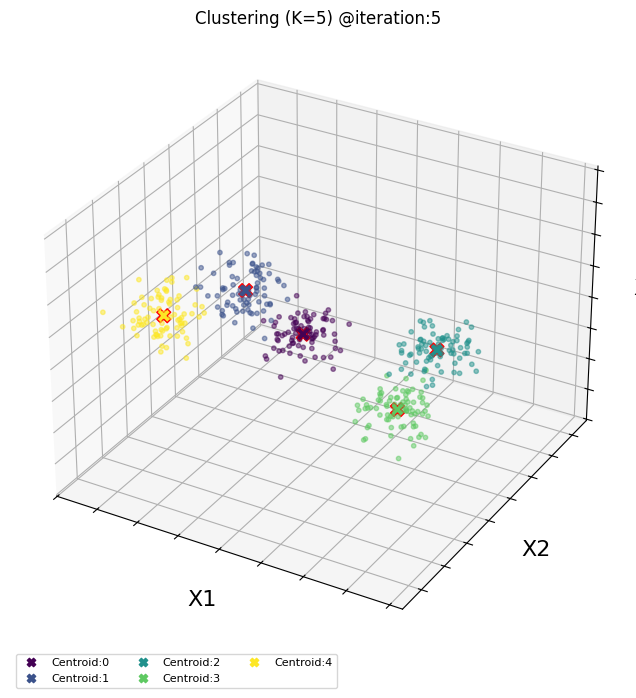

In [ ]:
# Visualise the best clustering.

labels, centroids = intermediates[-1] # Extract labels and centroids of last iteration.

# Visualise 3D data
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2],
           c=labels, s=10, alpha = 0.5) # s controls the marker
centroid_scatter = ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2],
                    alpha=1.0, marker='X', edgecolor='r',
                    c=np.arange(len(centroids)), s=100)

# Set Titles
ax.set_title(f'Clustering (K={len(centroids)}) @iteration:{len(intermediates) -1 }')
ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_zticklabels([]);
ax.set_xlabel('X1'); ax.set_ylabel('X2'); ax.set_zlabel('X3');

# Set Legend
plt.legend(handles=centroid_scatter.legend_elements()[0],
           labels=[f'Centroid:{i}' for i in range(len(centroids))],
           loc='upper left', numpoints=1, ncol=3, fontsize=8, bbox_to_anchor=(0, 0))

plt.show()


To visualise the intermediate clustering, we take a snapshot at every iteration and then compile them into a GIF animated plot. To do this, we define a function `update_plot` which produces the associated plot for a given iteration. You can then view the animation by opening it (it isn't automatically viewable inline - see comments at the end of the cell).

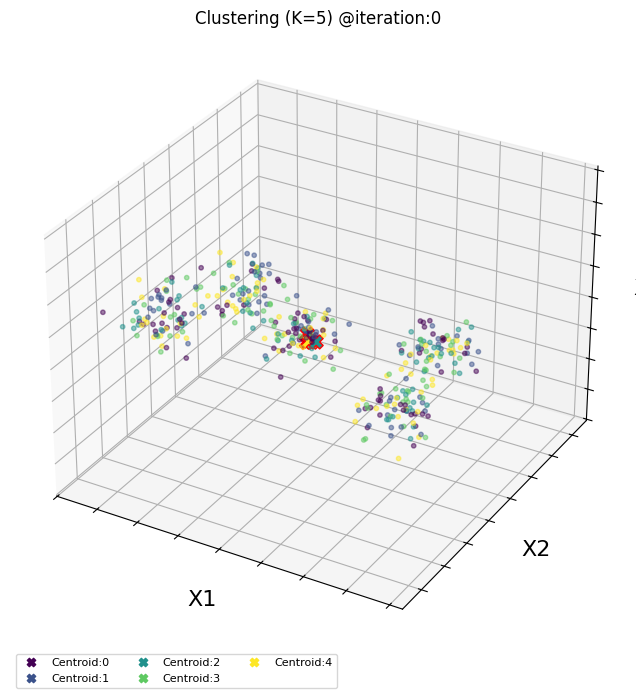

In [ ]:
fig = plt.figure(figsize=(12, 8));
ax = fig.add_subplot(111, projection='3d');

def update_plot(i):
    # clear the axis each frame
    ax.clear();
    labels, centroids = intermediates[i]

    ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_zticklabels([]);
    ax.set_xlabel('X1'); ax.set_ylabel('X2'); ax.set_zlabel('X3');
    ax.set_title(f'Clustering (K={len(centroids)}) @iteration:{i}');
    ax.scatter(X[:, 0], X[:, 1], X[:, 2],
               c=labels, s=10, alpha = 0.5);
    centroid_scatter = ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2],
                alpha=1.0, marker='X', edgecolor='r',
                c=np.arange(len(centroids)), s=100);
    ax.legend(handles=centroid_scatter.legend_elements()[0],
               labels=[f'Centroid:{i}' for i in range(len(centroids))],
               loc='upper left', numpoints=1, ncol=3, fontsize=8, bbox_to_anchor=(0, 0))

ani = animation.FuncAnimation(fig, update_plot,
                              frames=len(intermediates),
                              interval=1000);

# Save it as a GIF file in the current directory
ani.save(f'kmeans_K{K}.gif', writer='pillow');


# If you want to view the animation inline, you need to uncomment the following lines of code
# NOTE - this package will not be available during the in class test

#from IPython.display import Image
#Image(filename=f'kmeans_K{K}.gif')


#### Questions
1. Change the value for $K$ and observe how this changes the clustering.
2. How could you find the best $K$ without using the knowledge that the number of ground truth clusters is 5?
3. Also change the value of the `random_state` or set it to `None` in the data-generating function. Is the $K$-means algorithm good at finding overlapping clusters?

<a name="section-4"></a>

# Section 4: Hierarchical Clustering ([index](#outline))

One version of hierarchical clustering is the so called *agglomerative clustering*. In agglomerative clustering, we start by considering **each of the $N$ examples as a separate cluster**. The algorithm then proceeds to **merge pairs of clusters** starting with the pair that achieves a minimum linkage criterion. Then it successively repeats the merging of clusters until we **end up with one big cluster** comprising all the data points. Applying this scheme on our dataset we expect the following clustering trajectory.

![agglomerative](https://raw.githubusercontent.com/barahona-research-group/mfds-resources/main/images/agglomerative_clustering_average_link.gif)



### Pairwise distances

Now let's define a function that returns a Numpy array containing the Euclidean distances between every two samples in `X`, *i.e.* element $(i, j)$ of the array is the computed distance between i-th and j-th sample in X. We do this here without a for loop (hint: you need to use a list comprehension and pad with zeros).

In [ ]:
def pairwise_distances(X):
   '''
   Parameters:
       X (np.ndarray): Samples matrix, shape (N, p).
   Returns:
       distance (np.ndarray): Distance matrix, shape (N, N).
   '''
   N, D = X.shape

  # Apply zero padding with np.zeros and np.concatenate to prevent computing the same values twice.

   distance = np.array([np.concatenate([np.zeros(i + 1), np.sqrt(np.sum((X[i, :] - X[range(i + 1, N), :])**2, axis=1))]) for i in range(N)])

   return distance + distance.T

We can calculate the distance matrix for our generated data.

In [ ]:
distance = pairwise_distances(X)

You implementation should pass the following simple test case

In [ ]:
X_test = np.array([[-3, -4],
                   [0 , 0],
                   [3 , 4]])

npt.assert_allclose(pairwise_distances(X_test),
                    np.array([[0, 5, 10],
                              [5, 0, 5],
                              [10, 5, 0]]))

### Linkage

In the following, we are going to implement the agglomerative algorithm with two different *linkage* criteria, as listed in the notes:

- ***Simple linkage:*** a simple linkage between two clusters is the **minimum** distance between any pair of points from the two clusters.
-  ***Average linkage:*** an average linkage between two clusters is the **average** distance over all pairs of points from the two clusters.

We start by implementing a function which can compute any of the three linkage criteria:

In [ ]:
def linkage(distances, labels, i, j, linkage_type):
    """
    This function computes a matrix of distances between the samples of two clusters

    Parameters:
      distances (np.ndarray): Distance matrix, shape (N, N).
      labels (np.ndarray): Cluster index of each sample, shape (N,).
      i (int): The index of the first cluster.
      j (int): The index of the second cluster.
      linkage_type (string): The linkage type to be used,
                             either 'single' or 'average'.
    Returns:
      pairs_distance (np.ndarray): Distance matrix, shape (|c_i|, |c_j|).

    """
    # Select the indices of the first cluster.
    points_i = np.argwhere(labels == i) ## <-- SOLUTION
    # Select the point indices of the second cluster.
    points_j = np.argwhere(labels == j) ## <-- SOLUTION
    # Form a cartesian product between the indices in i and indices in j.
    pairs = np.array([[element_i.item(), element_j.item()]  for element_i in points_i for element_j in points_j])
    # Select the pair distances between the points in the two clusters from the distances matrix.
    pairs_distance = distances[pairs[:, 0], pairs[:, 1]]

    linkage_map = {
    'single': lambda x: x.min(),
    'average': lambda x: x.mean()
    } ## <- SOLUTION

    return linkage_map[linkage_type](pairs_distance)

We are now ready to implement the agglomerative hierarchical clustering algorithm. To speed things up, we define the `Pair` class which is used to consider a pair of clusters (*not* a pair of samples) and the distance between them. Here `distance` refers to the linkage between a pair of clusters. It utilises the 'less than' magic method to allow a comparison between the distance of two pairs of clusters.


In [ ]:
class Pair:
    """
    A pair of clusters.
    """
    def __init__(self, i: int, j: int, distance: float):
        """
        Args:
            i (int): The index of the first cluster.
            j (int): The index of the second cluster.
            distance (float): The distance between the two clusters.
        """
        self.i = i
        self.j = j
        self.distance = distance

    def __lt__(self, other):
        """
        Compare two pairs of clusters based on their distance.
        less-than definition.
        Args:
            other (Pair): The other pair of clusters.
        Returns:
            bool: True if this pair is less than the other pair.
        """
        return self.distance < other.distance

    def __repr__(self):
        """string representation"""
        return f'({self.i}, {self.j}, {self.distance})'

We now define the `hierarchical_clustering` function. To begin with, it assigns every sample to its own cluster (which are labelled $0:N-1$ respectively). When the new cluster is created from merging cluster $i$ and cluster $j$, it is named as $N$. The next cluster is named $N+1$, and so on.

This is illustrated here:

![joining_levels](https://raw.githubusercontent.com/barahona-research-group/mfds-resources/main/images/joining_levels_mfds.jpeg)



Here we use `heapify`, `heappop` and `heappush` to implement the "priority queue algorithm" to speed up the function which would otherwise be quite slow. You can read more about this package [here](https://docs.python.org/3/library/heapq.html). It helps identify the pair of clusters to merge at each level. It works by creating a `priority_queue`, which provides an ordering of pairs of cluster in order of highest priority *i.e.* lowest linkage distance (this is why we needed a "less-than" magic-method for the `Pair` class, we need to be able to compare pairs).

The function returns `labels`, an $N\times N$ array containing the cluster labels at each level i.e. the $(i,j)$ element denotes the cluster label of sample $j$ at level $i$ (with level $0$ representing all samples belonging to one cluster). This is illustrated below.

![levels_matrix](https://raw.githubusercontent.com/barahona-research-group/mfds-resources/main/images/level_matrix_mfds.png)


In [ ]:
def hierarchical_clustering(X, distances, linkage_type):
    """
    The agglomerative hierarchical clustering algorithm start with every point as a single
    cluster and each iteration merges two clusters into one. We store all the
    intermediate clustering results with respect to the number of clusters left.

    Parameters:
      X (np.ndarray): Samples matrix, shape (N, p).
      distances (np.ndarray): Distance matrix, shape (N, N).
      linkage_type (string): The linkage type to be used, either 'single', or 'average'.

    Returns:
     labels (np.ndarray):  Cluster labels at each level, shape (N, N).
          Element (i, j) denotes the cluster label of sample i at level j.
    """

    N, D = X.shape
    labels = np.zeros((N, N))

    # Begin with every point in its own cluster
    current_labels = np.arange(N)   # <-- SOLUTION

    # The id to be assigned for the next merged cluster
    next_cluster_id = N

    priority_queue = []
    # Initialise Priority Queue
    for i in range(N):
        for j in range(i + 1, N):
            priority_queue.append(Pair(i, j, distances[i, j]))
    heapify(priority_queue)

    labels[N - 1] = current_labels # the leaves
    # Begin from level (N - 1) to level 1
    for level in tqdm(range(N - 2, 0, -1)):
        # pop and return the smallest item in priority queue
        # i.e. the pair (i, j) of clusters which are closest together
        next_pair = heappop(priority_queue)

        # Remove pair of clusters in the queue which have i and j in them i.e. (i, j) or (j, i)
        priority_queue = [p for p in priority_queue if next_pair.i not in (p.i, p.j) and next_pair.j not in (p.i, p.j)]

        # re sort the queue
        heapify(priority_queue)

        # Merge all samples which currently belong to cluster i or j
        current_labels[(current_labels == next_pair.i) | (current_labels == next_pair.j)] = next_cluster_id

        # Compute the merging cost of the new cluster with all existing clusters to the queue
        for i in set(p.i for p in priority_queue) | set(p.j for p in priority_queue):
            d = linkage(distances, current_labels, i, next_cluster_id, linkage_type) ## <- SOLUTION
            heappush(priority_queue, Pair(i, next_cluster_id, d))

        next_cluster_id += 1
        # Store the current cluster assignment into the assignments array.
        labels[level, :] = current_labels ## <- SOLTUION

    # add the root labels
    labels[0, :] = next_cluster_id * np.ones(N)
    return labels

Your implementation should pass the following quick test.

In [ ]:
X_test = np.array([[-3, -4],
                   [0 , 0],
                   [3 , 4]])

test_distance = np.array([[0, 5, 10],
                              [5, 0, 5],
                              [10, 5, 0]])

npt.assert_allclose(hierarchical_clustering(X_test, test_distance, 'average'),
                     np.array([[4, 4, 4],
                               [0, 3, 3],
                               [0, 1, 2]]))

  0%|          | 0/1 [00:00<?, ?it/s]

We can now apply hierarchical clustering to our synthetic data.

In [ ]:
h_clustering = hierarchical_clustering(X, distance, 'average')

  0%|          | 0/398 [00:00<?, ?it/s]

Similarly to $K$-means clustering it is not easy to choose the best level in the dendrogram of hierarchical clustering. As we know that our data has 5 ground-truth clusters, we visualise level 4 below.

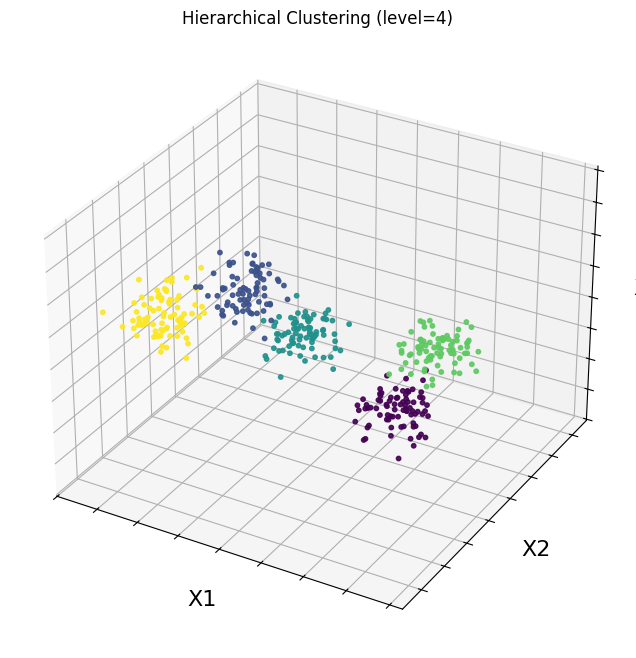

In [ ]:
level = 4

level_vals = list(sorted(set(h_clustering[level])))
simple_labels = [level_vals.index(v) for v in h_clustering[level]]

# Visualize the 3D data
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2],
           c=simple_labels, s=10, alpha = 0.9)


ax.set_title(f'Hierarchical Clustering (level={level})')
ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_zticklabels([]);
ax.set_xlabel('X1'); ax.set_ylabel('X2'); ax.set_zlabel('X3');

plt.show()

To visualise the clustering at all levels we produce another animation. Here we highlight the pair clusters that are going to joined at the next level.

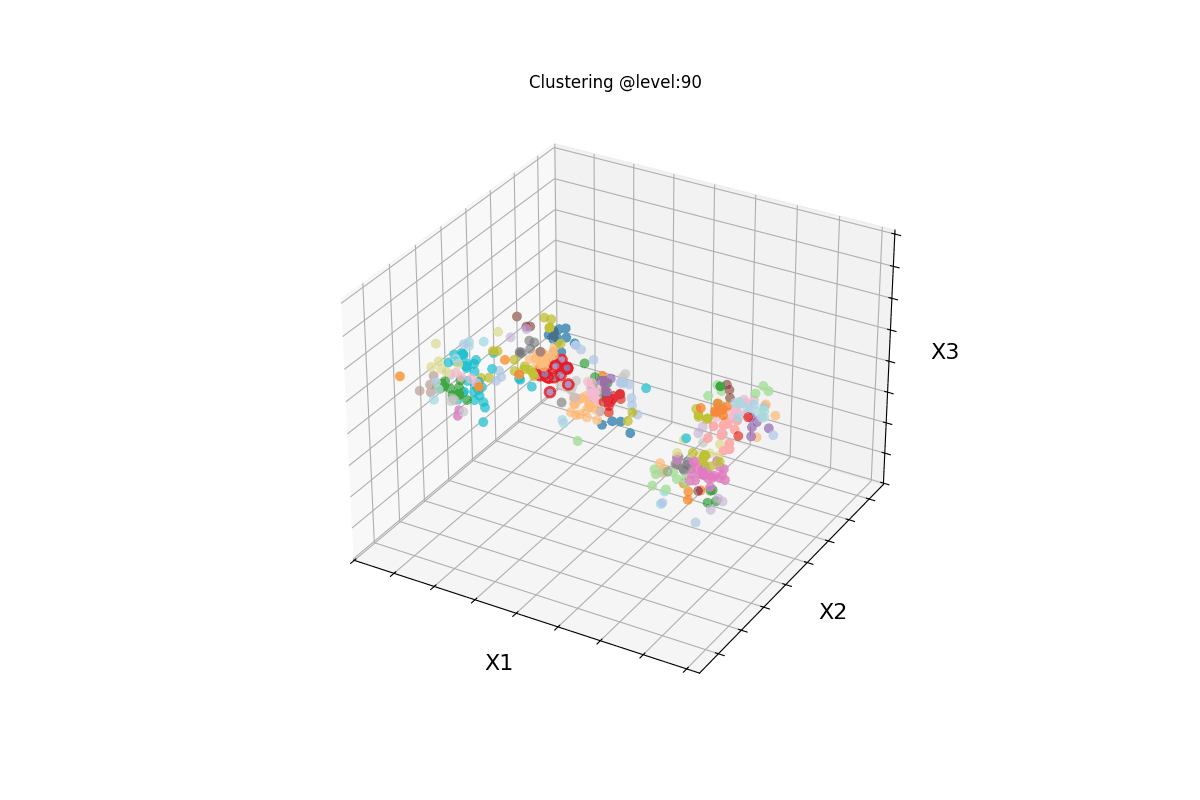

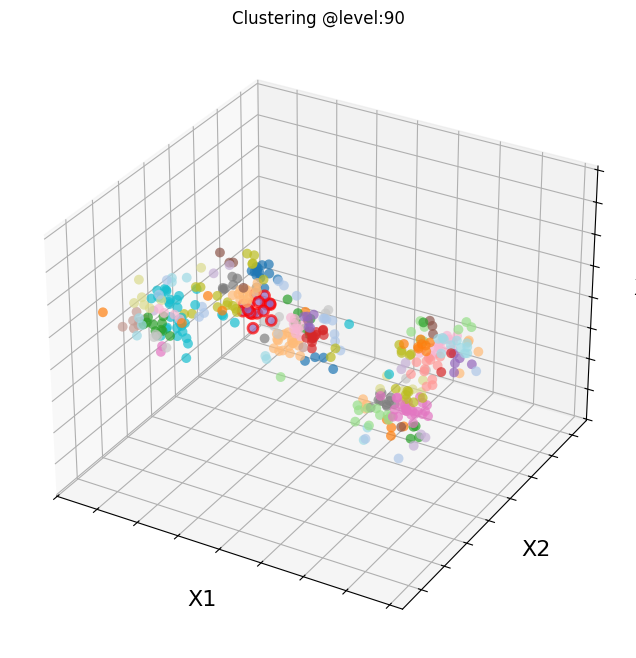

In [ ]:
cmap_colors = cm.tab20.colors

fig = plt.figure(figsize=(12, 8));
ax = fig.add_subplot(111, projection='3d');

# Select levels to show.
levels = list(range(10)) + list(range(10, 100, 10))
# Select those levels that are less than the number of levels in a
levels = [l for l in levels if l < len(h_clustering)]
def update_plot(i):
    # clear the axis each frame
    ax.clear();
    level = levels[len(levels) - i - 1]
    # extract the relevant clustering
    level_clusters = h_clustering[level]

    colors = np.array([cmap_colors[int(l) % 20] for l in level_clusters])

    ax.set_xticklabels([]); ax.set_yticklabels([]); ax.set_zticklabels([]);
    ax.set_xlabel('X1'); ax.set_ylabel('X2'); ax.set_zlabel('X3');
    ax.set_title(f'Clustering @level:{level}');

    # for those clusters which join at the next level add a red circle
    still_mask = (h_clustering[level] == h_clustering[min(level + 1, len(h_clustering) - 1)])
    ax.scatter(X[:, 0], X[:, 1], X[:, 2],
               c=colors, s=50, alpha = 0.7,
               linewidth=np.where(still_mask, 0, 2),
               edgecolor=np.where(still_mask, 'none', 'r'))


ani = animation.FuncAnimation(fig, update_plot,
                              frames=len(levels),
                              interval=1000);

# Save it as a GIF file in the current directory and open it.
ani.save(f'agglomerative_clustering_average_link.gif', writer='pillow');

# If you want to view the animation inline, you need to uncomment the following lines of code
# NOTE - this package will not be available during the in class test

#from IPython.display import Image
#Image(filename=f'agglomerative_clustering_average_link.gif')


#### Questions
1. What are the inherent advantages of hierarchical clustering over $K$-means?
2. Try out different linkage methods. Can you observe any differences? If so, where do these differences come from?
3. Can you replicate your results for both algorithms with sklearn?
4. Do both algorithms perform well on a [dataset of handwritten digits](https://scikit-learn.org/stable/datasets/toy_dataset.html#digits-dataset)?